In [1]:
# set this notebook one level above State_denoise_RNN. Then we can just keep 
# track of it with git and exchange it between the server and local
import os
path = os.getcwd()
# if "State" not in path:
#     subdirectory = "attractor_net_notebooks"
#     path = os.getcwd()[:-len(subdirectory)] + 'State_Denoised_RNN'
print(path)
# os.chdir(path)

/Users/denis/Dropbox/school/research/attractor_net_notebooks


In [72]:
# Layer Normalization [https://theneuralperspective.com/2016/10/27/gradient-topics/]
def ln(inputs, epsilon = 1e-5, scope = None):
 
    """ Computer LN given an input tensor. We get in an input of shape
    [N X D] and with LN we compute the mean and var for each individual
    training point across all it's hidden dimensions rather than across
    the training batch as we do in BN. This gives us a mean and var of shape
    [N X 1].
    """
    mean, var = tf.nn.moments(inputs, [1], keep_dims=True)
    with tf.variable_scope(scope + 'LN'):
        scale = tf.get_variable('alpha',
                                shape=[inputs.get_shape()[1]],
                                initializer=tf.constant_initializer(1))
        shift = tf.get_variable('beta',
                                shape=[inputs.get_shape()[1]],
                                initializer=tf.constant_initializer(0))
    LN = scale * (inputs - mean) / tf.sqrt(var + epsilon) + shift
 
    return LN

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10,5)


# import sys
# def progress_print(i, total, spacing=20):
#     if i % spacing == 0:
#         string_params_tuple = (i, total)
#         sys.stdout.write("\r%i / %i" % string_params_tuple)
#         sys.stdout.flush()

In [5]:
#!/usr/local/bin/python

# This version of the code trains the attractor connections with a separate
# objective function than the objective function used to train all other weights
# in the network (on the prediction task).

from __future__ import print_function
import itertools
import tensorflow as tf
import numpy as np
import sys
import argparse
import datetime

%load_ext autoreload
%autoreload 2


from tensorflow_helpers import *
from data_generator import generate_examples, pick_task
from information_trackers import MutInfSaver, WeightSaver, compute_entropy_fullvec, get_mut_inf_for_vecs,\
                                flat_mutual_inf, compute_avg_entropy_vec
from helper_functions import get_batches, load_pretrained_embeddings, \
                             get_model_type_str, translate_ids_to_words, \
                             save_results, print_into_log, print_some_translated_sentences, \
                             get_training_progress_comment
from graph_init import GRU_attractor

ops = {
        'model_type': "GRU", # OPTIONS: vanilla, LSTM_raw, LSTM_tensorflow, LSTM_attractor
        'hid': 50,
        'in': None, #TBD
        'out': 1,
#         'batch_size':n_examples, #since the sequences are 1-dimensional it's easier to just run them all at once
        'n_attractor_iterations': 8,
        'attractor_dynamics': "projection2", # OPTIONS:  "" (for no attractor dynamics),
                                    #           "direct" (simple attractor weights applied to hidden states directly, trained with noise addition)
                                    #           "projection" (project the hidden state into a separate space via weights, do attraction, project back)
                                    #           "helper_hidden" (hidden-hidden neurons) - IMPORTANT: don't forget to add h_hid number
        'h_hid': 75, # helper hidden for "helper hidden" "attractory_dynamics" mode
        'attractor_noise_level': 0.2,
        'attractor_noise_type': "bernoilli", # OPTIONS: "gaussian", "dropout", "random_drop"
    
        'training_mode': "",#'attractor_on_both',
    
        'attractor_regularization': "l2_norm", # OPTIONS: "l2_regularization", "l2_norm"
        'attractor_regularization_lambda': 0.05,
    
        'record_mutual_information': True,
        'problem_type': "pos_brown", # OPTIONS: parity, parity_length, majority, reber, kazakov, pos_brown
        'seq_len': 5,
    
        'save_best_model': True, 
        'reshuffle_data_each_replication': False, #relevant for POS datasets (since they are loaded from files)
        'test_partition': 0.3,
        'lrate': 0.008, # was 0.008
    
        # NLP related (pos_brown task)
        'bidirectional': True,
        'embedding_size': 100,
        'load_word_embeddings': True,
        'train_word_embeddings': False, 
        'input_type': "embed", # embed&prior, embed, prior
        'dropout': 0.2 # in range(0,1)
        }



# !!!!!!!!!!!!!!!!!!!!!!            
# SEQ_LEN = 12 # number of bits in input sequence   
N_HIDDEN = ops['hid']  # number of hidden units
N_H_HIDDEN = ops['h_hid']          
TASK = ops['problem_type']
ARCH = ops['model_type'] # hidden layer type: 'GRU' or 'tanh'
NOISE_LEVEL = ops['attractor_noise_level']
                      # noise in training attractor net 
                      # if >=0, Gaussian with std dev NOISE_LEVEL 
                      # if < 0, Bernoulli dropout proportion -NOISE_LEVEL 
            
# !!!!!!!!!!!!!!!!!!!!!! 
INPUT_NOISE_LEVEL = 0.1
ATTRACTOR_TYPE = ops['attractor_dynamics']
N_ATTRACTOR_STEPS = ops['n_attractor_iterations']
                      # number of time steps in attractor dynamics
                      # if = 0, then no attractor net
# !!!!!!!!!!!!!!!!!!!!!!            
# ATTR_WEIGHT_CONSTRAINTS = True
                      # True: make attractor weights symmetric and have zero diag
                      # False: unconstrained
TRAIN_ATTR_WEIGHTS_ON_PREDICTION = False
                      # True: train attractor weights on attractor net _and_ prediction
REPORT_BEST_TRAIN_PERFORMANCE = True
                      # True: save the train/test perf on the epoch for which train perf was best
LOSS_SWITCH_FREQ = 1
                      # how often (in epochs) to switch between attractor 
                      # and prediction loss

ops, SEQ_LEN, N_INPUT, N_CLASSES, N_TRAIN, N_TEST = pick_task(ops['problem_type'], ops)# task (parity, majority, reber, kazakov)


# Training Parameters

TRAINING_EPOCHS = 1
N_REPLICATIONS = 2
BATCH_SIZE = 10000 if N_TRAIN>10000 else N_TRAIN
DISPLAY_EPOCH = 5
LOG_DIRECTORY = 'experiments/logs/{}_(att_iter{}__bidir{}__drop{}).txt'.format(ops['problem_type'],
                                                                              ops['n_attractor_iterations'],
                                                                               ops['bidirectional'],
                                                                               ops['dropout'])



# NOTEBOOK CODE
WS = WeightSaver()
MIS = MutInfSaver()



######### MAIN CODE #############################################################
for attractor_steps in [5,10]:
    # the tf seed needs to be within the context of the graph. 
    tf.reset_default_graph()
    np.random.seed(100)
    tf.set_random_seed(100)
#     ops['n_attractor_iterations'] = attractor_steps


    #
    # PLACEHOLDERS
    #
    if 'pos' in ops['problem_type']:
        # X will be looked up in the embedding table, so the last dimension is just a number
        X = tf.placeholder("int64", [None, SEQ_LEN], name='X')
        # last dimension is left singular, tensorflow will expect it to be an id number, not 1-hot embed
        Y = tf.placeholder("int64", [None, SEQ_LEN], name='Y')
    else: #single output
        X = tf.placeholder("float", [None, SEQ_LEN, N_INPUT])
        Y = tf.placeholder("float", [None, N_CLASSES])
    attractor_tgt_net = tf.placeholder("float", [None, N_HIDDEN], name='attractor_tgt')

    # Embedding matrix initialization
    if 'pos' in ops['problem_type']:
        [X_train, Y_train, X_test, Y_test, maps] = generate_examples(SEQ_LEN, N_TRAIN, N_TEST, 
                                                                             INPUT_NOISE_LEVEL, TASK, ops)
        if ops['load_word_embeddings']:
            embeddings_loaded = load_pretrained_embeddings('data/glove.6B.{}d.txt'.format(ops['embedding_size']), maps, ops)
            embedding = tf.get_variable("embedding",
                                    initializer=embeddings_loaded,
                                    dtype=tf.float32,
                                    trainable=ops['train_word_embeddings'])
        else: #initialize randomly
            embedding = tf.get_variable("embedding",
                                    initializer=tf.truncated_normal_initializer(stddev=0.05),
                                    shape=[ops['vocab_size'], ops['embedding_size']],
                                    dtype=tf.float32,
                                    trainable=ops['train_word_embeddings'])
        embed_lookup = tf.nn.embedding_lookup(embedding, X)

        # load priors information
        if ops['input_type'] == 'prior' or ops['input_type'] == 'embed&prior':
            id2prior = maps['id2prior']
            word2id = maps['word2id']
            priors = np.zeros([len(id2prior), len(id2prior[0])]).astype("float32")
            for id, prior in id2prior.items():
                priors[id] = prior
            priors_op = tf.get_variable("priors",
                                    initializer=priors,
                                    dtype=tf.float32,
                                    trainable=False)
            prior_lookup = tf.nn.embedding_lookup(priors_op, X)

        if ops['input_type'] == 'embed':
            embed = embed_lookup
        elif ops['input_type'] == 'prior':
            embed = prior_lookup
        elif ops['input_type'] == 'embed&prior':
            embed = tf.concat([embed_lookup, prior_lookup], axis=2)




    # Graph + all the training variables
    if 'pos' in ops['problem_type']:
        net_inputs={'X': embed, 'Y': Y, 'attractor_tgt_net': attractor_tgt_net}
    else:
        net_inputs={'X': X, 'Y': Y, 'attractor_tgt_net': attractor_tgt_net}
    
    if ops['bidirectional']:
        G_attractors = {'forw':[], 'back':[]}
        names = G_attractors.keys()
        # Forward:
        G_forw = GRU_attractor(ops, inputs=net_inputs, direction='forward', suffix=names[0])
        attr_loss_op_forw = G_forw.attr_loss_op
        attr_train_op_forw = G_forw.attr_train_op
        h_clean_seq_flat_forw = G_forw.h_clean_seq_flat # for computing entropy of states
        h_net_seq_flat_forw = G_forw.h_net_seq_flat # -> attractor_tgt_net placeholder
        G_attractors['forw'] = {'attr_loss_op': attr_loss_op_forw, "attr_train_op": attr_train_op_forw,
                    'h_clean_seq_flat': h_clean_seq_flat_forw, 'h_net_seq_flat': h_net_seq_flat_forw}
        G_forw_output = G_forw.output

        # Backward:
        G_back = GRU_attractor(ops, inputs=net_inputs, direction='backward', suffix=names[1])
        attr_loss_op_back = G_back.attr_loss_op
        attr_train_op_back = G_back.attr_train_op
        h_clean_seq_flat_back = G_back.h_clean_seq_flat # for computing entropy of states
        h_net_seq_flat_back = G_back.h_net_seq_flat # -> attractor_tgt_net placeholder
        G_attractors['back'] = {'attr_loss_op': attr_loss_op_back, "attr_train_op": attr_train_op_back,
                    'h_clean_seq_flat': h_clean_seq_flat_back, 'h_net_seq_flat': h_net_seq_flat_back}
        G_back_output = G_back.output

        # Merge: [seq_len, batch_size, n_hid*2]
        # Note that we reverse the backward cell's output to align with original direction
        output = tf.concat([G_forw_output, tf.reverse(G_back_output, axis=[0])], axis=2)
        
        if ops['dropout'] > 0.0:
            # note keep_prob = 1.0 - drop_probability (not sure why they implemented it this way)
            # tensorflow implementation scales by 1/keep_prob automatically
            output_dropped = tf.nn.dropout(output, keep_prob=1.0 - ops['dropout'])
        else:
            output_dropped = output
        
        input_size_final_projection = 2*ops['hid']
        Y_ = project_into_output(Y, output, input_size_final_projection ,ops['out'], ops)

        # LOSS, ACC, & TRAIN OPS
        pred_loss_op = task_loss(Y, Y_, ops)
        optimizer_pred = tf.train.AdamOptimizer(learning_rate=0.008)
        prediction_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TASK_WEIGHTS")
        pred_train_op = optimizer_pred.minimize(pred_loss_op, var_list=prediction_parameters)
        accuracy = task_accuracy(Y, Y_, ops)
    else:
        # TODO: change to map with just ont entry as well. 
        G = GRU_attractor(ops, inputs=net_inputs)
        attr_loss_op = G.attr_loss_op
        attr_train_op = G.attr_train_op
        output = G.output

        h_clean_seq_flat = G.h_clean_seq_flat 
        h_net_seq_flat = G.h_net_seq_flat # -> attractor_tgt_net placeholder
        h_attractor_collection = G.h_attractor_collection
        input_size_final_projection = ops['hid']
        Y_ = project_into_output(Y, output, input_size_final_projection ,ops['out'], ops)

        # LOSS, ACC, & TRAIN OPS
        pred_loss_op = task_loss(Y, Y_, ops)
        optimizer_pred = tf.train.AdamOptimizer(learning_rate=0.008)
        prediction_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TASK_WEIGHTS")
        pred_train_op = optimizer_pred.minimize(pred_loss_op, var_list=prediction_parameters)
        accuracy = task_accuracy(Y, Y_, ops)





    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    print_into_log(LOG_DIRECTORY, get_model_type_str(ops, N_TRAIN, N_TEST, SEQ_LEN))

    with tf.Session() as sess:
        # TODO: make a class for all "best" quantities (a lot of space)
        saved_train_acc = []
        saved_test_acc = []
        saved_epoch = []
        saved_att_loss = []
        saved_entropy_final = []
        saver = tf.train.Saver()
        
        
        # Start training
        for replication in range(N_REPLICATIONS):
            print("********** replication ", replication," **********")
            [X_train, Y_train, X_test, Y_test, maps] = generate_examples(SEQ_LEN, N_TRAIN, N_TEST, 
                                                                         INPUT_NOISE_LEVEL, TASK, ops)

            print(X_test[0:1], Y_test[0:1])
            sess.run(init) # Run the initializer
    
            train_prediction_loss = True
            best_train_acc = -1000.
            best_test_acc = 0
            best_entropy = 0.0
            best_att_loss = 0
            for epoch in range(1, TRAINING_EPOCHS + 2):
                if (epoch-1) % DISPLAY_EPOCH == 0:
                    ploss, train_acc = batch_tensor_collect(sess, [pred_loss_op, accuracy], 
                                                            X, Y, X_train, Y_train, BATCH_SIZE)
                    test_acc = batch_tensor_collect(sess, [accuracy], X, Y, X_test, Y_test, BATCH_SIZE)[0]

                    # ATTRACTOR(s) LOSS 
                    aloss = {}
                    entropy = {}
                    hid_vals_arr = batch_tensor_collect(sess, [A['h_net_seq_flat'] for att_name, A in G_attractors.items()], 
                                                                      X, Y, X_train, Y_train, BATCH_SIZE)
                    h_clean_val_arr = batch_tensor_collect(sess, [A['h_clean_seq_flat'] for att_name, A in G_attractors.items()], 
                                                                      X, Y, X_train, Y_train, BATCH_SIZE)
                    for i, attractor_name in enumerate(G_attractors.keys()):
                        A = G_attractors[attractor_name]
                        a_loss_val = []
                        for batch_hid_vals in np.array_split(hid_vals_arr[i], int(len(X_train)/BATCH_SIZE)):
                            a_loss_val.append(sess.run(A['attr_loss_op'],feed_dict={attractor_tgt_net: batch_hid_vals}))
                        aloss[attractor_name] = "{:.4f}".format(np.mean(a_loss_val))
                        
                        entropy[attractor_name] = "{:.4f}".format(compute_entropy_fullvec(h_clean_val_arr[i], ops, n_bins=8))
                    
                    
                    # TODO: some issue with printing
                    # Print some examples:
                    if 'pos' in ops['problem_type']:
                        print_some_translated_sentences(sess, output, X, X_train, Y_train, maps, ops, n_rand_sentences=1)
                    # Print training information:
                    print_into_log(LOG_DIRECTORY, get_training_progress_comment(epoch, ploss, aloss, train_acc, test_acc, entropy) + '\n')
                    # Update the logs:
                    WS.update_conservative(epoch_number = epoch, loss_att = aloss, 
                                           loss_task = ploss, acc = test_acc, entropy=entropy)
    #                 if ops['record_mutual_information']:
    # #                     h_attractor_val, h_clean_val = sess.run([h_attractor_collection, h_clean_seq_flat],
    # #                                                                    feed_dict={X: X_train, Y: Y_train})
    #                     # TODO: h_attractor_collection reshapeing masking. 
    #                     h_attractor_val = None
    #                     h_clean_val = batch_tensor_collect(sess, [h_clean_seq_flat],
    #                                                                         X, Y, X_train, Y_train, BATCH_SIZE)[0]
    #                     MIS.update(ploss, aloss, train_acc, test_acc, np.tanh(hid_vals), h_attractor_val, h_clean_val)

                    if (train_acc > best_train_acc):
                        best_train_acc = train_acc
                        best_test_acc = test_acc
                        best_att_loss = aloss
                        save_path = saver.save(sess, "experiments/models/{}_{}.ckpt".format(datetime.date.today(), ops['problem_type']))
                        print_into_log("experiments/models/{}_{}.txt".format(datetime.date.today(), ops['problem_type']), get_model_type_str(ops, N_TRAIN, N_TEST, SEQ_LEN))
                        best_entropy = compute_entropy_fullvec(h_clean_val_arr[i], ops, n_bins=8)
                    if (1.0 - train_acc - 1e-15 < 0.0):
                        print('reached_peak')
                        break

                if epoch > 1 and LOSS_SWITCH_FREQ > 0 \
                             and (epoch-1) % LOSS_SWITCH_FREQ == 0:
                    train_prediction_loss = not train_prediction_loss

                # MODEL TRAINING
                batches = get_batches(BATCH_SIZE, X_train, Y_train)
                for (batch_x, batch_y) in batches:
                    if (LOSS_SWITCH_FREQ == 0 or train_prediction_loss):
                        # Optimize all parameters except for attractor weights
                        _ = sess.run([pred_train_op], 
                                               feed_dict={X: batch_x, Y: batch_y})
                    if (LOSS_SWITCH_FREQ == 0 or not train_prediction_loss):
                        if (N_ATTRACTOR_STEPS > 0):
                            # ATTRACTOR(s) training
                            for i, attractor_name in enumerate(G_attractors.keys()):
                                A = G_attractors[attractor_name]
                                _ = sess.run(A['attr_train_op'], feed_dict={attractor_tgt_net: hid_vals_arr[i]})

            print("Optimization Finished!")

        
            if (REPORT_BEST_TRAIN_PERFORMANCE):
                saved_train_acc.append(best_train_acc)
                saved_test_acc.append(best_test_acc)
                saved_att_loss.append(best_att_loss)
                saved_entropy_final.append(best_entropy)
            else: 
                saved_train_acc.append(train_acc)
                saved_test_acc.append(test_acc)
    #             saved_att_loss.append(aloss)
            if (train_acc == 1.0):
                saved_epoch.append(epoch)
        
        save_results(ops, saved_train_acc, saved_test_acc, saved_att_loss, saved_entropy_final,
                     N_TRAIN, N_TEST, SEQ_LEN, comment="pos_experiment")







The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(17202, 50)
Loading embeddings...
(400000, ' words loaded!')
1 words not found in pretrained embeddings: ['PAD']
L2 norm
L2 norm
Logged Successfully: 

    model_type: 		GRU bidir(True), task: pos_brown
    hid: 			50,
    h_hid: 			75
    n_attractor_iterations: 	5,
    attractor_dynamics: 	projection2
    attractor_noise_level: 	0.2
    attractor_noise_type: 	bernoilli
    attractor_regu-n: 		l2_norm(lambda:0.05)
    word_embedding: size	(100), trainFalse
    dropout: 			0.2
    TRAIN/TEST_SIZE: 	40138/17202, SEQ_LEN: 50
********** replication  0  **********
(17202, 50)
[[  13 1084    5 4212    2   13    7 2186    5 4212 4037   45   10  128
    59   39   55   71 1219   42    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]] [[ 2  1  8  1  6  2  3  4  8  4  1 55 24  9  3 47 42 22 11 23  5  0  0  0

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

In [8]:
save_results(ops, saved_train_acc, saved_test_acc, saved_att_loss, saved_entropy_final,
                     N_TRAIN, N_TEST, SEQ_LEN, comment="pos_experiment")

Saved Results Successfully


In [21]:
for i, attractor_name in enumerate(G_attractors.keys()):
    A = G_attractors[attractor_name]
    _ = sess.run(A['attr_train_op'], feed_dict={attractor_tgt_net: hid_vals_arr[i]})

['a', '2']

# Mutual information calculation

In [38]:

def process_each_training_example(MIS, mode, skip=1):
    # get_mut_inf_for_vecs(MIS.h_inits[57].reshape(-1, ops['hid']), MIS.h_inits[57].reshape(-1, ops['hid']))
    collect = []
    losses_skipped = []
    for id in range(0, len(MIS.losses_task), skip):
        progress_print(id, len(MIS.losses_task), 20)
        if mode == 'over_attractor_iterations':
            mut_infs = flat_mutual_inf(MIS.h_inits[id], MIS.h_attractors[id], MIS.h_finals[id], ops)
            collect.append(mut_infs)
            losses_skipped.append(MIS.losses_task[id])
            print(MIS.losses_task[id])

            
        elif mode == 'scatter_perf_entropy':
            entropy_avg = compute_avg_entropy_vec(MIS.h_finals[id], ops, n_bins=5)
            collect.append(entropy_avg)
        elif mode == 'entropy_vector':
            entropy_avg = compute_entropy_fullvec(MIS.h_finals[id], ops, n_bins=8)
            collect.append(entropy_avg)
    return collect, losses_skipped

# iteration_mut_inf, losses_skipped = process_each_training_example(MIS, 
#                                                                   'over_attractor_iterations', 
#                                                                   skip=1)
entropy_collection, _ = process_each_training_example(MIS, 'entropy_vector')

480 / 483

In [16]:
entropy_collection

[2.5373616220500907,
 2.2504288132633374,
 2.3397795401015986,
 2.4547661599726687,
 2.5026599279975814,
 2.1251283636015517,
 2.0307863905815138,
 2.1124670890334034,
 1.6393571728898637,
 1.8196018712777813,
 2.3523255764133322,
 2.051366785229932,
 2.0022522352506993,
 1.8106065286069846,
 1.9120938008117834,
 1.6563681180040444,
 1.3046529387058465,
 1.6255211964749063,
 1.6732597590970173,
 1.8353896871835809,
 1.7641506325868952,
 1.8118471088414798,
 1.7859032546751654,
 1.8079884173742491,
 1.9719892436826809,
 1.8613673115632083,
 1.8999996832857415,
 2.0901977995655199,
 1.8358614224153484,
 1.7115719913917544,
 1.7942217398605487,
 1.8960682833853624,
 1.9262255471786405,
 1.9909540134802908,
 1.8642140095854609,
 1.8642140095854611,
 1.859585671463591,
 2.1535515102000251,
 1.9902830605666357,
 2.2918422780811598,
 2.0651493519899158,
 2.0663172626926447,
 1.9381406360421316,
 1.8790684905799135,
 2.0663172626926447,
 2.1028734802666533,
 2.1070972205514575,
 1.974784572919

In [54]:
entropy_collection1

[9.0007759771516476, 8.6483462110677021]

In [38]:
a = np.array([[1,0], [0,1], [0,1], [0,1]])
print(a.shape)
np.unique([[1,0], [0,1], [0,1], [0,1]], return_counts=True, axis=0)


(4, 2)


(array([[0, 1],
        [1, 0]]), array([3, 1]))

In [408]:
x = np.array([1,1,1,2,2,2,5,25,1,1])
unique, counts = np.unique(x, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 1  5]
 [ 2  3]
 [ 5  1]
 [25  1]]


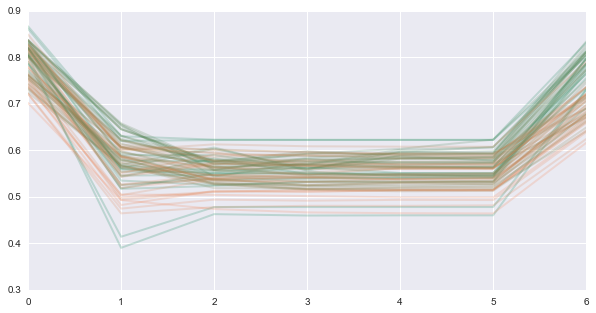

In [114]:
def plot_inf_iteration_loss(X, losses):
    losses = np.clip(losses, 0, 1)
    #     print(losses)
    n_iterations = len(X[0])
    color_gradient = np.array(range(len(losses)))/len(losses)
    for i in range(len(X)):# 
        if X[i] != []:
            X_plot = X[i]
            plt.plot(range(n_iterations), X_plot, 
                     #c =(np.abs(losses[i]),0.5,0.3), 
                     c = (i*1.0/len(losses),0.5,0.3),
                     linewidth=2.0, alpha=0.2)
  
    title = "experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           "mutual_information(Layersvs.TaskLoss)(not_scaled)")
#     plt.savefig(title, format='png', dpi=600)
    plt.show()


        
plot_inf_iteration_loss(iteration_mut_inf, losses_skipped)

In [43]:
entropy_collection1

[7.0005916923052949,
 0.44424140200116347,
 2.3459398752309912,
 5.2798343478483432,
 8.3127010550928535,
 9.6659404023199276,
 10.161910885956228,
 10.803302216370071,
 11.069488626403537,
 10.666800499323758,
 11.205508353886659,
 11.110032479522269,
 10.984439497740599,
 10.780766965062959,
 10.445212268957825,
 10.644215494440065,
 10.595740987367265,
 10.81804023656828,
 11.052490959875854,
 10.867472978291822,
 11.270053685766399,
 11.307787953086683,
 11.631576154876866,
 11.867088268863732,
 11.880701385488772,
 11.697213240772232,
 11.765768688498806,
 11.846536706625956,
 11.807783336740309,
 11.681010524903852,
 11.848425424824999,
 12.195143812932672,
 11.901987659544805,
 12.16807394173933,
 11.860511775381649,
 11.943937573511711,
 11.977226344565551,
 12.125965888782446,
 12.247772455297962,
 11.939531861953144,
 11.665176050515369,
 11.787655376036634,
 11.75754340170457,
 11.731041015643374,
 11.841673367998068,
 12.02543539905872,
 12.040148182523419,
 12.084283113634

[167, 334, 409]


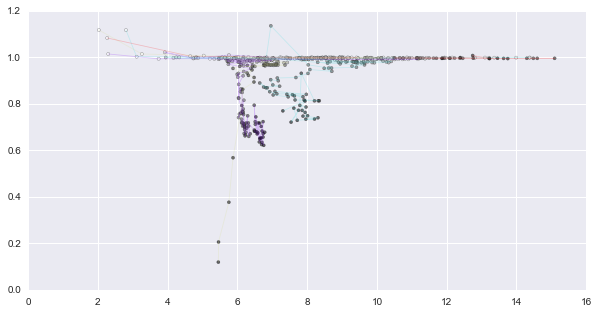

In [46]:
import matplotlib.cm as cm

def plot_entropy_scatter(X, losses):
    ids = [0]
    for i in range(len(losses)):
        if losses[i] == 0.0:
            ids.append(i)
    ids += [-1]
    print(ids)    
    colors = cm.rainbow(np.linspace(0, 1, len(ids)-1))
    for i in range(len(ids)-1):
        x = X[ids[i]:ids[i+1]]
        y = losses[ids[i]:ids[i+1]]
        color_gradient = np.array(range(len(x)))/len(x)
        plt.scatter(x, y, s=10, alpha=0.6, c=color_gradient)
        plt.plot(x, y, linewidth=0.8, alpha=0.2, c=colors[i])
#     plt.colorbar()
#     plt.axis([10, 14, 4.06, 4.1])
    title = "../attractor_net_notebooks/experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           "30repts_vectorentropy_vs_taskloss(projection2 5-10, bins{})".format(8))
    #     plt.savefig(title, format='png', dpi=600)

def plot_alossscaled_loss(X, losses, att_losses, ids_split):
    X = np.split(X, ids_split)
    losses = np.split(losses, ids_split)
    att_losses = np.split(att_losses, ids_split)
    
    
    colors = cm.rainbow(np.linspace(0, 1, len(ids_split)+1))
    print(ids_split)
    for i in range(len(ids_split) + 1):
        entropy = X[i]
        att_loss = att_losses[i]
#         x = att_loss/entropy
        x = entropy/att_loss
        
        y = losses[i]
        
        color_gradient = np.array(range(len(x)))/len(x)
        plt.scatter(x, y, s=10, alpha=0.6, c=color_gradient)
        plt.plot(x, y, linewidth=0.8, alpha=0.2, c=colors[i])
#     plt.colorbar()
#     plt.axis([10, 14, 4.06, 4.1])
    title = "../attractor_net_notebooks/experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           "30repts_vectorentropy_vs_taskloss(projection2 5-10, bins{})".format(8))
    #     plt.savefig(title, format='png', dpi=600)
    
# plot_entropy_scatter(entropy_collection2, MIS.losses_task)

epoch_normalized, ids_split = normalize_epoch_count(WS.epoch_number_history)
plot_alossscaled_loss(entropy_collection, MIS.losses_task, MIS.alosss, ids_split)
plt.show()

In [23]:
MIS.losses_task

[1.0257728,
 1.0283231,
 1.0346788,
 1.0140396,
 1.0054067,
 1.0042365,
 1.0054901,
 1.0038393,
 1.0025334,
 1.0036126,
 1.0028274,
 1.0021732,
 1.002589,
 1.00335,
 1.0022883,
 1.0007362,
 1.0003569,
 1.0002024,
 1.0003202,
 1.0008647,
 1.000555,
 1.0003005,
 1.0003548,
 1.0001917,
 1.0000762,
 1.0000248,
 0.99995387,
 1.000053,
 1.0000397,
 0.99998987,
 0.99993753,
 0.9999088,
 0.99985123,
 0.99982911,
 0.99982083,
 0.99983144,
 0.9998197,
 0.99983764,
 0.99977851,
 0.99976146,
 0.99976712,
 0.99977398,
 0.99982262,
 0.99978983,
 0.99969912,
 0.99964845,
 0.99955565,
 0.99951237,
 0.99955225,
 0.99953485,
 0.99944961,
 0.99927372,
 0.9989993,
 0.998909,
 0.99892783,
 0.99875504,
 0.99848187,
 0.9981513,
 0.99792379,
 0.99764657,
 0.99727976,
 0.99669075,
 0.99621952,
 0.99554718,
 0.9945569,
 0.99348688,
 0.99325371,
 0.9925614,
 0.9914701,
 0.99120045,
 0.99178624,
 0.98823625,
 0.98778439,
 0.98822546,
 0.98704684,
 0.98586363,
 0.98586512,
 0.98494768,
 0.98481125,
 0.98470676,
 0

# Noise removal plots

In [28]:
MIS_saved_10attractorsteps_5everythingelse = MIS

# Analyze Losses

In [26]:
def normalize_epoch_count(a):
    "splits the array into separate sessions and normalizes each session by its maximum id (epoch number)"
    maxs = []
    ids = []
    for i in range(len(a) - 1):
        if a[i+1] < a[i]:
            maxs.append(a[i])
            ids.append(i+1)
    maxs.append(a[-1])
    
    a_split = (np.split(a, ids))
    a_split_norm = [1.0*a_split[i]/maxs[i] for i in range(len(maxs))]
#     print(a_split_norm)
    return np.concatenate(a_split_norm, axis=0), ids

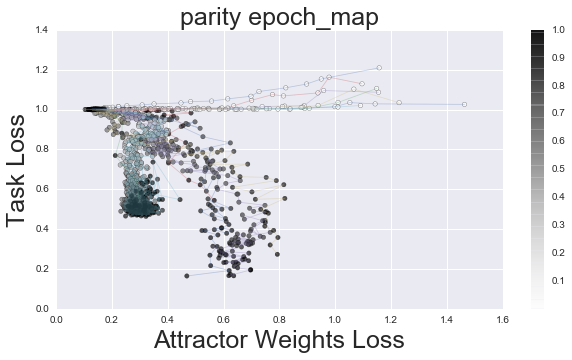

In [27]:
def plot_loss_vs_loss_vs_values(x, y, values, x_label="", y_label="", value_name="", ops=ops, comment=''):
    # Plot...
    plt.scatter(x, y, c=values, s=20, alpha=0.5) # 10*np.arange(1.0, 50.0)
    plt.xlabel(x_label, fontsize=25)
    plt.ylabel(y_label, fontsize=25)
    plt.title("{}".format(value_name), fontsize=25)
    plt.colorbar()
    title = "experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           comment)
    
    plt.axis([0, 3, -0.1, 1.1]) 
#     plt.savefig(title, format='png', dpi=600)

def plot_loss_vs_loss_vs_values_lines(x, y, values, ids_split, x_label="", y_label="", value_name="", ops=ops, comment=''):
    # Plot...
    x_list = np.split(x, ids_split)
    y_list = np.split(y, ids_split)
    values_list = np.split(values, ids_split)
    for i in range(len(ids_split) + 1):# 
        x = x_list[i]
        y = y_list[i]
        values = values_list[i]
        plt.scatter(x, y, c=values, s=20, alpha=0.7) # 10*np.arange(1.0, 50.0)
        plt.plot(x, y, linewidth=0.8, alpha=0.3)
        
    plt.xlabel(x_label, fontsize=25)
    plt.ylabel(y_label, fontsize=25)
    plt.title("{}".format(value_name), fontsize=25)
    plt.colorbar()
    title = "../attractor_net_notebooks/experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, seq_len<{}>,n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           SEQ_LEN,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           ops['attractor_regularization'],
                                                           comment)
    
#     plt.axis([0, 5, 4, 4.25]) 
#     plt.savefig(title, format='png', dpi=600)


epoch_normalized, ids_split = normalize_epoch_count(WS.epoch_number_history)
plot_loss_vs_loss_vs_values_lines(WS.losses_att, 
                            WS.losses_task,
                            epoch_normalized,
                            ids_split,
                           'Attractor Weights Loss',
                           'Task Loss',
                           ops['problem_type'] + ' epoch_map', 
                           comment = "Test_acc_mean<{:.4f}>, <bothlosses>".format(np.mean(saved_test_acc)))
# plt.savefig('figs/' + "{}vs{}vs{}__".format(x_label, y_label, value_name) + 
#                "NoiseLambda_{}__Architecture_{}".format(str(ops['attractor_noise_level']), model_type))
plt.show()



In [65]:
        
comment = "both losses used for attractor training"
save_results(ops, saved_train_acc, saved_test_acc, saved_att_loss, comment)




(2018-03-19): both losses used for attractor training
<NETWORK>:
model_type: 		GRU,
hid: 			5, 
h_hid: 			10
n_attractor_iterations: 0,
attractor_dynamics: 	projection2
attractor_noise_level: 	0.2
attractor_noise_type: 	bernoilli
attractor_regu-n: 	l2(lambda:0.05)
TRAIN/TEST_SIZE: 	1000/1000, SEQ_LEN: 12
<RESULTS>:
type: 			mean: 	 var: 	
saved_train_acc 	0.8055 	 0.0132
saved_test_acc 		0.5912 	 0.0217
saved_att_loss 		1.0049 	 0.0000
TRAIN:[0.646 0.749 0.766 0.699 0.685 0.996 0.731 0.763 0.740 0.690 1.000 0.694
 0.736 0.763 0.766 0.732 0.940 0.999 0.658 0.969 0.902 0.822 0.712 0.856
 0.989 0.733 1.000 0.752 0.777 0.901]
TEST:[0.498 0.520 0.562 0.502 0.510 0.868 0.499 0.528 0.506 0.503 0.990 0.499
 0.513 0.481 0.572 0.488 0.564 0.825 0.515 0.772 0.559 0.547 0.512 0.545
 0.762 0.506 0.995 0.524 0.487 0.587]
ATT_LOSS:[1.005 1.005 1.005 1.005 1.005 1.005 1.004 1.005 1.005 1.005 1.005 1.005
 1.005 1.004 1.005 1.004 1.005 1.005 1.005 1.005 1.005 1.005 1.005 1.005
 1.005 1.005 1.005 1.005

In [33]:
saved_att_loss

[0.27380559]

In [ ]:
saved_train_acc = []
saved_test_acc = []
saved_epoch = []

In [ ]:
get_mean_var(saved_test_acc)

In [ ]:
np.mean(saved_test_acc)
